# Ames Housing Sale Price Predictions

## Executive Summary

This report analyses the Ames Housing Data and to provide better predictions of Ames Housing Sale Prices, given descriptive features of the type, condition and information to the respectives houses.

### Problem Statement and Objective:
When houses go on sale, buyers want to get as sense of what kind of houses can fit within their budget. Each buyer has their own preferences and aspects they wish to forgo when considering their budget. 

The aim is to create a model to accurately predict these housing prices, given their information and make better recommendations to these buyers.

### Contents:
- [Train Data Cleaning](#Train-Data-Cleaning)
- [Exploratory Data Analysis](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Test Data Cleaning](#Test-Data-Cleaning)
- [Modelling](#Modelling)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

In [86]:
#import all the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
%matplotlib inline

### Data import

In [2]:
#reading out test data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_test = pd.read_csv('../datasets/test.csv', keep_default_na=False)
df_train = pd.read_csv('../datasets/train.csv', keep_default_na=False)

# Train Data Cleaning

In [3]:
#replacing '' and 'None' with None
df_train = df_train.replace({'':None, 'None':None})

In [4]:
df_train.isnull().sum().head()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
dtype: int64

In [5]:
#lower case columns
df_train.columns= df_train.columns.str.lower()
def remove_spaces(dataframe):
    dataframe.columns = [i.replace(' ','_') for i in dataframe.columns]
remove_spaces(df_train)

In [6]:
df_train.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [7]:
df_train.dtypes.head()

id               int64
pid              int64
ms_subclass      int64
ms_zoning       object
lot_frontage    object
dtype: object

### Converting to correct data types

In [8]:
#list of numeric columns but identified as ibject 
obj_to_num = ['lot_frontage', 'lot_area', 'year_built',
               'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1',
               'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
               '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
               'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
               'full_bath', 'half_bath', 'bedroom_abvgr',
               'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
               'garage_yr_blt', 'garage_cars', 'garage_area',
                'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
                '3ssn_porch', 'screen_porch', 'pool_area',
                'misc_val', 'mo_sold', 'yr_sold']

In [9]:
#converting into proper numeric datatypes
#making it a function so that we can use it later for our test data
def object_to_float(dataframe):
    for i in obj_to_num:
        dataframe[i] = pd.to_numeric(dataframe[i])
        
    #pid and ms_subclass although numbers are unique IDs and should be str
    dataframe['pid'] = dataframe['pid'].astype(str)
    dataframe['ms_subclass'] = dataframe['ms_subclass'].astype(str)
    
    #central air is a Y/N should be binary too
    dataframe['central_air'] = (dataframe['central_air']=='Y')*1
    
    
object_to_float(df_train)

In [10]:
df_train.shape

(2051, 81)

### Imputing our Null Values

In [11]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

mas_vnr_type      1240
lot_frontage       330
garage_yr_blt      114
mas_vnr_area        22
bsmt_exposure        4
bsmtfin_type_2       2
bsmt_half_bath       2
bsmt_full_bath       2
garage_cond          1
bsmt_cond            1
bsmtfin_type_1       1
garage_finish        1
garage_cars          1
garage_area          1
bsmtfin_sf_2         1
garage_qual          1
bsmtfin_sf_1         1
bsmt_qual            1
total_bsmt_sf        1
bsmt_unf_sf          1
dtype: int64

In [12]:
#checking our null values
print(df_train['mas_vnr_type'].value_counts())
df_train['mas_vnr_type'].fillna('None', inplace=True)

BrkFace    630
Stone      168
BrkCmn      13
Name: mas_vnr_type, dtype: int64


In [13]:
#If garage area is 0, there isnt a garage and it is safe to impute the garage_yr_blt with year_built
print(df_train[['year_remod/add','garage_yr_blt','year_built','garage_area']].isnull().sum())
df_train['garage_yr_blt'].fillna(df_train['year_built'], inplace=True)

year_remod/add      0
garage_yr_blt     114
year_built          0
garage_area         1
dtype: int64


In [14]:
#replacing Lot Frontage Null values with the mean
df_train['lot_frontage'].fillna(df_train['lot_frontage'].mean(), inplace=True)

#replace Mas Vnr Area Null values with the mean
df_train['mas_vnr_area'].fillna(df_train['mas_vnr_area'].mean(), inplace=True)

# the rest with single digit null values are relatively negligible due to the scale of the data and as such shall just be dropped
df_train.dropna(inplace=True)

In [15]:
#converting the floats and obj to int, we dont want decimals
def convert_int(x):
    for i in x:
        df_train[x] = df_train[x].astype(int)
convert_int(obj_to_num)

Just a quick summary of our cleaned dataset:

In [16]:
#my computer is a 32bit
df_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('int32')], dtype=object)

In [17]:
df_train.shape

(2044, 81)

### Preliminary Feature Engineering

We can combine a couple of columns together to acquire a different set of features.

In [18]:
df_train.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [19]:
#aggregating the total number of baths
df_train['total_bath'] = df_train['bsmt_full_bath']+df_train['full_bath']+ 0.5*(df_train['bsmt_half_bath'])+0.5*(df_train['half_bath'])
#Age of house
df_train['age'] = df_train['yr_sold']-df_train['year_built']
#total functional area
df_train['total_liv_sf'] = df_train['total_bsmt_sf']+df_train['1st_flr_sf']+df_train['2nd_flr_sf']

# EDA

In [20]:
#separating our numerical and nominal columns
obj_train = df_train.select_dtypes(include='object').columns.values.tolist()
obj_train.remove('pid')
int_train = df_train.select_dtypes(include=['int64','int32']).columns.values.tolist()
int_train.remove('id')

### Removing our outliers in salesprice

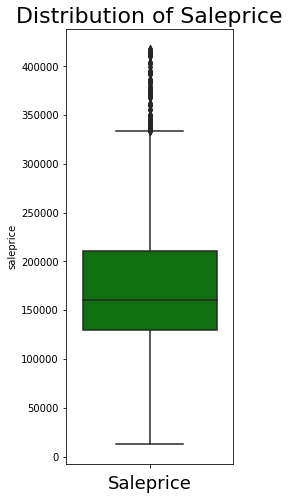

In [91]:
#We want to remove outliers in saleprices
plt.figure(figsize=(3,8))
sns.boxplot(x= df_train['saleprice'], orient='v', color='g');
plt.title('Distribution of SalePrice', fontsize = 22)
plt.xlabel('Saleprice',fontsize=18);

In [22]:
print('Mean:',df_train['saleprice'].mean())
print('Std deviation:',df_train['saleprice'].std())
print('Max Considerable Price:', df_train['saleprice'].mean()+3*(df_train['saleprice'].std()))

Mean: 181394.14872798434
Std deviation: 79285.50687430595
Max Considerable Price: 419250.6693509022


In [23]:
#anything more than 3 sigma of the mean is considered an outlier and should be dropped
df_train = df_train[(df_train['saleprice'] < 420000)]

### Boxplots of all our object typed features

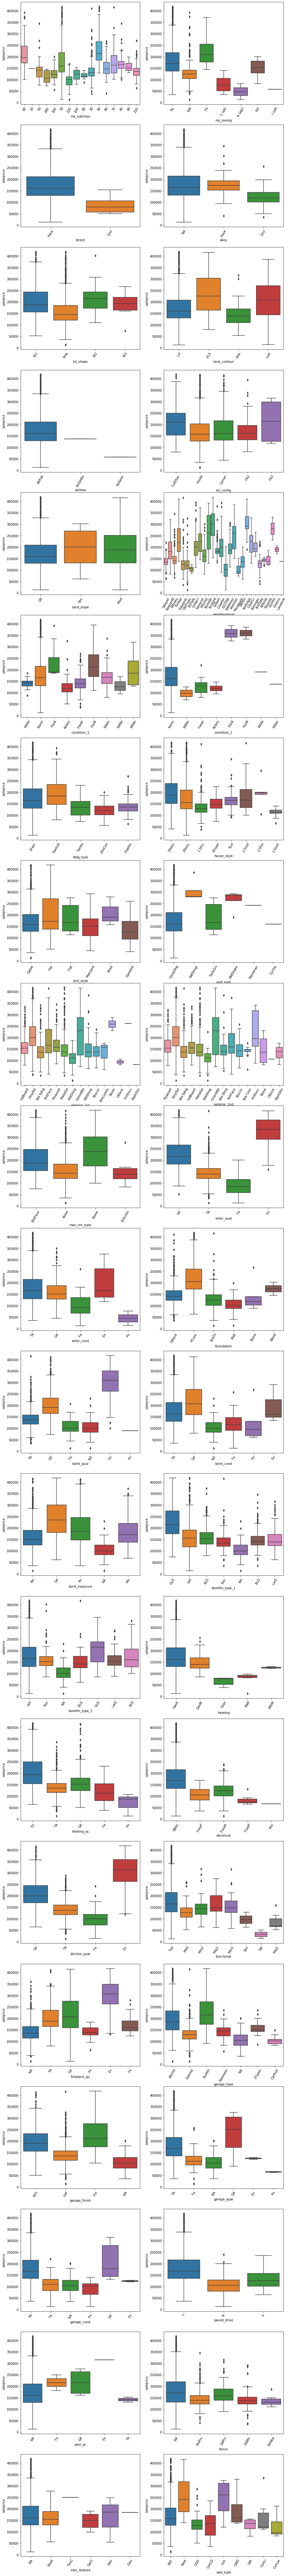

In [24]:
#creating boxplots for all our object typed columns against SalePrice
#This is to simply see if there are any columns that we do not want to include in our correlation matrix
#The numerical ones will be sieved out from the .corr function
fig, axes= plt.subplots(nrows=21, ncols=2, figsize=(15,150))
axes = axes.ravel()
for i, object_t in enumerate(obj_train):
    box = sns.boxplot(x=object_t, y='saleprice', data= df_train, ax= axes[i])
    x_ticks = df_train[object_t].unique()
    box.set_xticklabels(labels = x_ticks, rotation = 60 )

### Observations
The vast majority properties hold a specific combination one would say.  
For example, Majority of Alleys are NA, Utilities are AllPub, Misc Features are NA, and Heating are GasA.  
Columns such as these, we do not want to include.
  
Some such as Neighborhood are quite peculiar with StoneBrridgHt and NoRidge seeming to be the more expensive Neighborhoods. Despite the majority of Condition 2 being Norm, PosA and PosN stand out quite a fair bit.
However, due to the majority being a specific category, these would generally hold less influence on the model we want to build.

**Features such as MS Zoning, Neighborhood, Condition 2, Fireplace Qu, Bsmt Qual, Roof Mtl, External Qual, Exter Cond, and Street** stand out quite a bit and should be considered.

In [25]:
nom_train = ['ms_zoning','neighborhood','condition_2','fireplace_qu','bsmt_qual','roof_matl','exter_qual','exter_cond','street']

In [26]:
len(int_train)
df_train_numeric = df_train[int_train]

In [27]:
#processing the entirely numerical dataset via .corr would be better than eyeballing boxplots

plus_not_bad_corr = (df_train_numeric.corr()['saleprice'].sort_values())  # getting all the corr coeff for SalesPrice
plus_not_bad_corr = pd.DataFrame(plus_not_bad_corr)  #making it a dataframe
plus_4_corr = plus_not_bad_corr[plus_not_bad_corr.saleprice>0.4].index.values.tolist() #extracting all that are > 0.4
minus_4_corr = plus_not_bad_corr[plus_not_bad_corr.saleprice<-0.4].index.values.tolist() #extracting all that are <-0.4
not_bad_corr = plus_4_corr + minus_4_corr

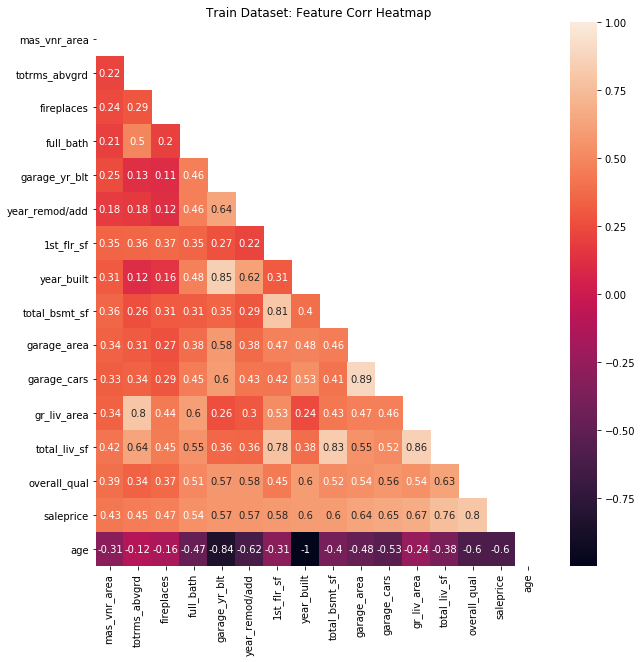

In [28]:
#plotting heatmap of the features >0.4 and <-0.4 on the Pearson correlation scale
plt.figure(figsize=(10,10))
mask = np.zeros_like(df_train[not_bad_corr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train[not_bad_corr].corr(), annot = True, mask = mask)
plt.title('Train Dataset: Feature Corr Heatmap');

Here we have mulitple colinear variables and we should choose one out of the two:  
Garage Yr Built vs Year Built  
Ground Living Area vs Total Rooms Above Ground  
Garage Cars vs Garage Area  
Total Bsmt SF vs 1st Floor SF  
We've selected Year built, Ground Living Area, Garage Area and 1st Floor SF.

In [29]:
#removing colinear variables from our features
dw_this=['garage_yr_blt', 'totrms_abvgrd','garage_cars','total_bsmt_sf', 'total_liv_sf']
for i in dw_this:
    not_bad_corr.remove(i)
not_bad_corr

['mas_vnr_area',
 'fireplaces',
 'full_bath',
 'year_remod/add',
 '1st_flr_sf',
 'year_built',
 'garage_area',
 'gr_liv_area',
 'overall_qual',
 'saleprice',
 'age']

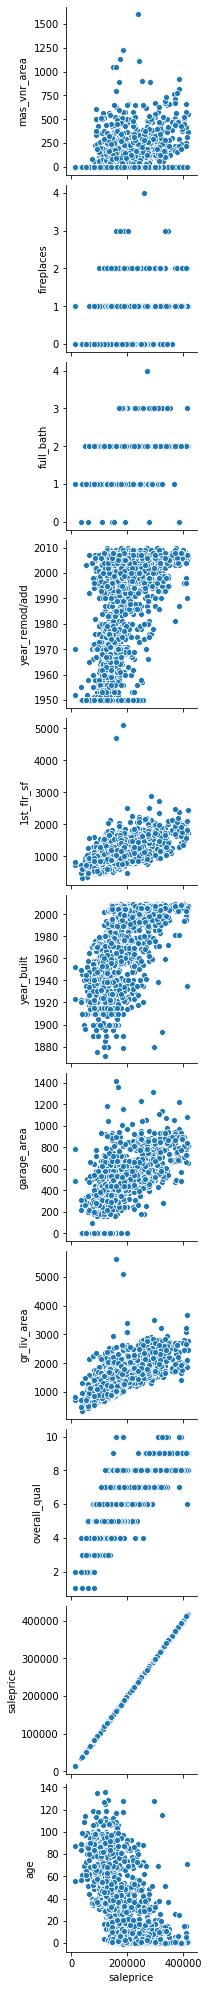

In [30]:
#creating a pairplot
sns.pairplot(df_train, y_vars=not_bad_corr, x_vars=['saleprice']);

In [31]:
#removal of outliers found in pairplot
df_train = df_train[df_train['gr_liv_area']<4000]
df_train = df_train[df_train['1st_flr_sf']<4000]
df_train = df_train[df_train['mas_vnr_area']<1500]

In [32]:
df_train_work = df_train[not_bad_corr]

# Feature Engineering

## One-hot encoding our chosen nominal features

In [33]:
# Get dummy columns and drop original columns
for col in nom_train:
    df_train_work = pd.concat([df_train_work, pd.get_dummies(df_train[col],prefix=col)], axis=1)

In [34]:
df_train_work.head()

,mas_vnr_area,fireplaces,full_bath,year_remod/add,1st_flr_sf,year_built,garage_area,gr_liv_area,overall_qual,saleprice,age,ms_zoning_A (agr),ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition_2_Artery,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,fireplace_qu_Ex,fireplace_qu_Fa,fireplace_qu_Gd,fireplace_qu_NA,fireplace_qu_Po,fireplace_qu_TA,bsmt_qual_Ex,bsmt_qual_Fa,bsmt_qual_Gd,bsmt_qual_NA,bsmt_qual_Po,bsmt_qual_TA,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,exter_qual_Ex,exter_qual_Fa,exter_qual_Gd,exter_qual_TA,exter_cond_Ex,exter_cond_Fa,exter_cond_Gd,exter_cond_Po,exter_cond_TA,street_Grvl,street_Pave
0,289,0,2,2005,725,1976,475,1479,6,130500,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
1,132,1,2,1997,913,1996,559,2122,7,220000,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
2,0,0,1,2007,1057,1953,246,1057,5,109000,57,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
3,0,0,2,2007,744,2006,400,1444,5,174000,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
4,0,0,2,1993,831,1900,484,1445,6,138500,110,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [35]:
len(df_train_work.columns)

82

In [36]:
df_train_work.corr()['saleprice'].sort_values(ascending=False)[:20]

saleprice               1.000000
overall_qual            0.802517
gr_liv_area             0.698080
garage_area             0.642130
1st_flr_sf              0.615708
year_built              0.596857
year_remod/add          0.568516
full_bath               0.540192
exter_qual_Gd           0.530260
bsmt_qual_Ex            0.518838
fireplaces              0.469846
mas_vnr_area            0.445248
neighborhood_NridgHt    0.415364
exter_qual_Ex           0.380175
fireplace_qu_Gd         0.366603
bsmt_qual_Gd            0.314353
neighborhood_NoRidge    0.281538
ms_zoning_RL            0.234935
fireplace_qu_Ex         0.208916
fireplace_qu_TA         0.191520
Name: saleprice, dtype: float64

# Test Data Cleaning

In [37]:
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NA,Detchd,1910,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,,9662,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NA,Attchd,1977,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58,17104,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60,8520,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NA,Detchd,1935,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,,9500,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NA,NA,NA,0,7,2009,WD


In [38]:
df_test.columns=df_test.columns.str.lower()
remove_spaces(df_test)
object_to_float(df_test)

### Imputing our null values

In [39]:
df_test.isnull().sum().sort_values(ascending=False).head()

lot_frontage     160
garage_yr_blt     45
mas_vnr_area       1
sale_type          0
exter_qual         0
dtype: int64

In [40]:
df_test['lot_frontage'].fillna(df_train['lot_frontage'].mean(), inplace=True)

In [41]:
df_test['garage_yr_blt'].fillna(df_test['year_built'], inplace=True)

In [42]:
df_test['mas_vnr_area'].fillna(df_train['mas_vnr_area'].mean(), inplace=True)

In [43]:
#need to add our feature engineered 'age'
df_test['age'] = df_test['yr_sold']-df_test['year_built']

### One-hot encoding our test data

In [44]:
not_bad_corr.remove('saleprice')

In [45]:
df_test_work = df_test[not_bad_corr]

In [46]:
for col in nom_train:
    df_test_work = pd.concat([df_test_work, pd.get_dummies(df_test[col],prefix=col)], axis=1)

In [47]:
df_test_work.shape

(879, 75)

In [48]:
df_train_work.shape

(2008, 82)

# Modelling

In [49]:
features = set(df_train_work.columns).intersection(set(df_test_work.columns))

In [50]:
#assignging our X and Y
X=df_train_work[features]
y=df_train['saleprice']

In [51]:
#confirming they are the correct sizes
print(X.shape)
y.shape

(2008, 73)


(2008,)

In [52]:
#we do train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y)

In [53]:
#fitting the X_train
ss = StandardScaler()
ss.fit(X_train)
#scaling of x_train and x_test after fitting.
X_train_sc= ss.transform(X_train)
X_test_sc = ss.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

### Baseline RMSE

In [55]:
baseline = pd.DataFrame(np.full(len(y_test),y.mean()))
np.sqrt(metrics.mean_squared_error(y_test,baseline))

71983.2707320933

### Comparing our models

In [56]:
#Instantiate our models to see which is the best to use
lasso= LassoCV(n_alphas = 300)
ridge = RidgeCV(alphas = np.linspace(0.1,10,300))

In [57]:
#cross validate our 2 models
lasso_scores = cross_val_score(lasso, X_train_sc, y_train).mean()
ridge_scores = cross_val_score(ridge, X_train_sc, y_train).mean()
print(lasso_scores)
print(ridge_scores)

In [59]:
#cross validate our 2 models
lasso_rmse = np.sqrt(-cross_val_score(lasso, X_train_sc, y_train, scoring='neg_mean_squared_error').mean())
ridge_rmse = np.sqrt(-cross_val_score(ridge, X_train_sc, y_train, scoring='neg_mean_squared_error').mean())
print(lasso_rmse)
print(ridge_rmse)

The Lasso model produced higher R^2 and lowest RMSE as such it will be selected as our working model.

### Lasso

In [61]:
#fitting the train dataset to our model
lasso.fit(X_train_sc, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=300, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [62]:
lasso.score(X_train_sc, y_train) #train r^2

0.8797143837355378

In [63]:
lasso.score(X_test_sc, y_test)  #test r^2

0.8873077340323882

In [64]:
lasso_scores.mean() #r^2 of our full train set

0.8611573157056677

In [65]:
#acquire our predictions
predictions = lasso.predict(X_test_sc)

In [66]:
#acquire residuals
residuals = y_test-predictions

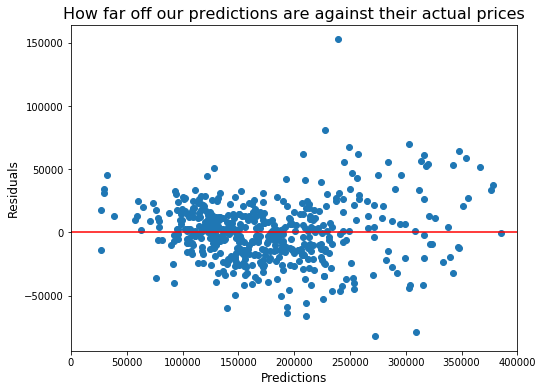

In [67]:
#seeing how our predictions fare against our residuals on a scatter plot
plt.figure(figsize=(8,6))
plt.scatter(predictions,residuals)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('How far off our predictions are against their actual prices', fontsize=16)
plt.hlines(y=0, xmin=0, xmax=400000, color='r')
plt.xlim(0,400000);

In [68]:
#seeing the reduced features and the adjusted coefficients
lasso.coef_

array([ 1.60478165e+03,  8.57154345e+02, -0.00000000e+00, -1.94012393e+03,
       -1.50359513e+03,  4.88619466e+03,  0.00000000e+00, -1.33677810e+03,
        1.28935877e+03,  7.18982886e+02,  1.55423072e+03, -7.43663287e+02,
       -6.70673697e+02,  8.56758600e+02, -1.45001548e+02,  1.04663069e+03,
        6.01799289e+03,  1.91307972e+03,  0.00000000e+00,  0.00000000e+00,
        3.55969926e+03, -0.00000000e+00, -1.25183647e+03,  0.00000000e+00,
       -1.89716365e+03,  6.64807844e+02,  1.08138377e+03,  1.86686661e+04,
        1.27135286e+03, -8.89821126e+02, -1.74897199e+03, -9.20235913e+02,
        6.55632775e+03, -1.76565352e+02,  0.00000000e+00,  0.00000000e+00,
       -8.33737183e+02, -7.78700563e+02, -1.92805073e+01,  8.48088343e+03,
       -2.41028589e+03,  2.50058017e+02, -0.00000000e+00, -2.28453456e+01,
       -1.89860408e+03,  3.21067767e+03, -1.26009570e+03,  0.00000000e+00,
        1.83775725e+03,  0.00000000e+00, -8.98000152e+02, -3.55509998e+03,
       -5.58079354e+01, -

In [70]:
#creating a dataframe to better visualise this
df_coef = pd.DataFrame(lasso.coef_, index = list(features) )

#tidying up the index
df_coef = df_coef.reset_index()

#naming our columns
df_coef.columns = ['Features','Coefficient']

In [74]:
#These are the biggest positive influencers
df_coef.sort_values(by='Coefficient', ascending =False).head()

,Features,Coefficient
27,gr_liv_area,18668.666096
65,overall_qual,13440.744712
55,bsmt_qual_Ex,8671.142238
39,1st_flr_sf,8480.883434
32,garage_area,6556.327753


In [85]:
#These are the biggest negative influencers
df_coef.sort_values(by='Coefficient', ascending =True).head()

,Features,Coefficient
60,age,-7995.570472
70,ms_zoning_RM,-3582.514593
51,exter_qual_TA,-3555.099984
40,bsmt_qual_NA,-2410.285889
3,neighborhood_Edwards,-1940.123927


### Interpretation of Coefficients

So basically:  
For every unit of Ground Living Area the price increases by USD 18,668.  
More area, more expensive.  
For every unit of Overall Quality the price increases by USD 13,440.  
Higher quality, more expensive.   
For every unit of Age the price decreases by USD 7,995.  
Older the house, cheaper it gets.   

### Applying Model

In [75]:
#assigning our x from testdata, with the reduced features
X = df_test_work[features]
X_sc = ss.transform(X)

#finally using our model on the test data
predictions = lasso.predict(X_sc)

#checking we're getting the same number of predictions
print(df_test_work.shape)
len(predictions)

In [81]:
#assigning the predicted SalePrice to our test dataframe
df_test['saleprice'] = predictions

In [82]:
#filtering to match the format required for submission to kaggle
answer = df_test[['id','saleprice']]

In [84]:
#saving it as a csv file to submit to kaggle
answer.to_csv('../datasets/answer.csv', index = False)

# Conclusion and Recommendation

After creating our model, the house prices generally rely on a specific set of features. The model however is generalised and will not accurately predict exceptions to the norm. Nonetheless, knowing the features will give a better estimate of a housing price and therefore provide better recommendations to those working with a budget.  
Here we have determined that ther higher the Ground Living Area and Overall Quality the more significantly expensive the estate would be. Also the younger the estate, the more expensive it gets and therefore those on a budget might consider compromising some Living Area, Quality and consider older houses.